In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import joblib

# Visualization settings
sns.set(style="whitegrid")
%matplotlib inline

print("Libraries imported successfully.")


Libraries imported successfully.


**Load Data & Basic Inspection**

In [238]:

 # Load Data


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Data loaded successfully.")


Data loaded successfully.


In [239]:

#  Basic Inspection


print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

print("\nFirst 5 rows of training data:")
display(train.head())

print("\nMissing Values in Training Data:")
display(train.isnull().sum().sort_values(ascending=False))


Train Shape: (891, 12)
Test Shape: (418, 11)

First 5 rows of training data:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Missing Values in Training Data:


,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


**Exploratory Data Analysis (EDA)**

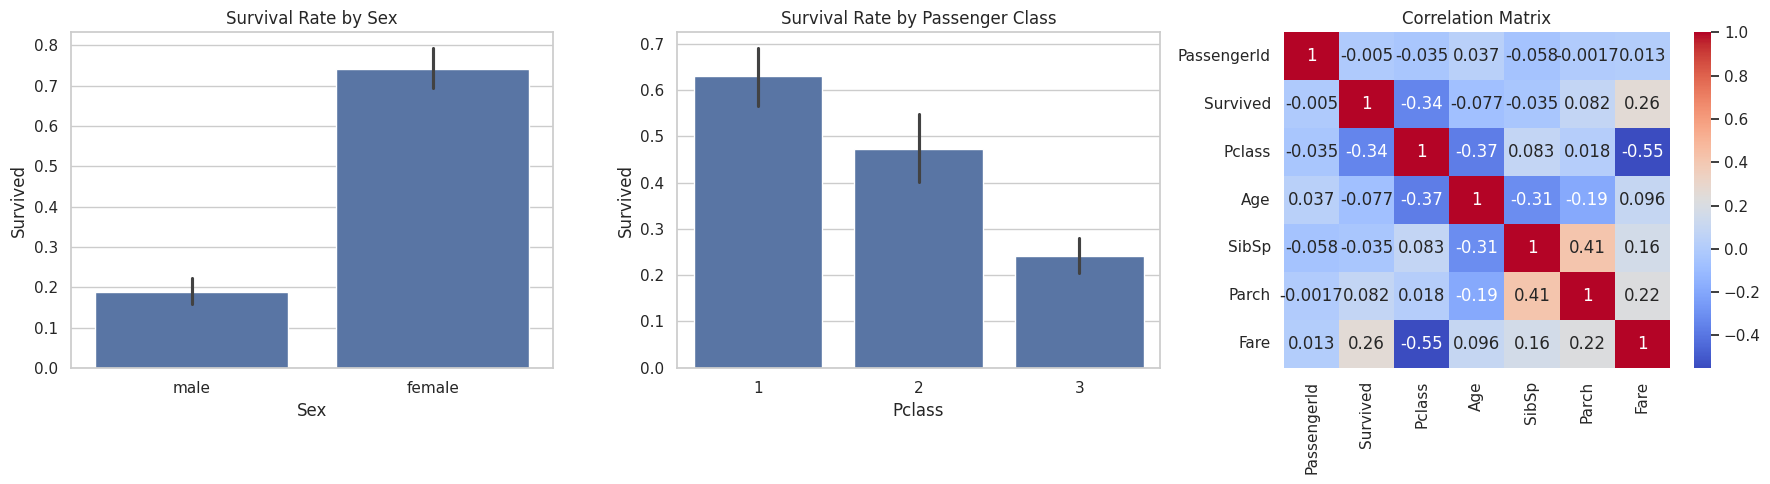

In [240]:

#  Quick EDA


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#  1 Survival by Sex
sns.barplot(x='Sex', y='Survived', data=train, ax=axes[0])
axes[0].set_title("Survival Rate by Sex")

# 2 Survival by Passenger Class
sns.barplot(x='Pclass', y='Survived', data=train, ax=axes[1])
axes[1].set_title("Survival Rate by Passenger Class")

# 3 Correlation Matrix (Numerical Only)
corr_matrix = train.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title("Correlation Matrix")

plt.tight_layout()
plt.show()


**Feature Engineering Function**

In [241]:

#  Feature Engineering Function


def engineer_features(df):
    df = df.copy()

    # 1 Extract Title from Name
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

    # 2 Group rare titles
    rare_titles = ['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                   'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']

    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    # 3 Drop unused columns
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

    return df

print("Feature engineering function created.")


Feature engineering function created.


In [242]:

#  Apply Feature Engineering


X_full = engineer_features(train)
X_test_submission = engineer_features(test)

# Separate target
y = X_full['Survived']
X = X_full.drop('Survived', axis=1)

print("Feature engineering applied.")
print("New shape:", X.shape)


Feature engineering applied.
New shape: (891, 8)


**Define Feature Types**

In [243]:

#  Define Feature Types


numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title']

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)


Numeric Features: ['Age', 'SibSp', 'Parch', 'Fare']
Categorical Features: ['Pclass', 'Sex', 'Embarked', 'Title']


**Build Numerical & Categorical Pipelines**

In [244]:

#  Build Individual Pipelines


# 1 Numerical Pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # Fill missing numeric values
    ('scaler', StandardScaler())                     # Standardize features
])

# 2 Categorical Pipeline
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categories
    ('encoder', OneHotEncoder(handle_unknown='ignore'))    # Convert to binary columns
])

print("Numerical and Categorical pipelines created.")


Numerical and Categorical pipelines created.


**Build the Full Preprocessor**

In [245]:

# ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ]
)

print("Full preprocessing pipeline created.")


Full preprocessing pipeline created.


**Train/Test Split (Stratified)**

In [246]:

#  Train / Validation Split


X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,      # preserves class distribution
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

print("\nSurvival distribution in Training set:")
print(y_train.value_counts(normalize=True))

print("\nSurvival distribution in Validation set:")
print(y_val.value_counts(normalize=True))


Training set shape: (712, 8)
Validation set shape: (179, 8)

Survival distribution in Training set:
Survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64

Survival distribution in Validation set:
Survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


**Build Full Model Pipeline**

In [247]:

#  Full Model Pipeline


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    ))
])

# Train the model
model.fit(X_train, y_train)

print("Model trained successfully.")


Model trained successfully.


**Evaluate Model on Validation Set**

Validation Accuracy: 0.8268

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       110
           1       0.84      0.68      0.75        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



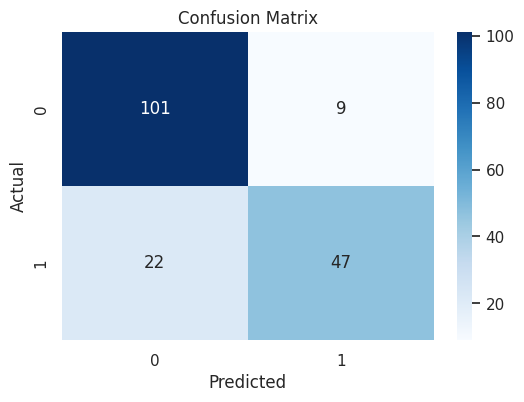

In [248]:

#  Model Evaluation


# 1 Predict on Validation Set
y_pred = model.predict(X_val)

# 2 Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# 3 Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# 4 Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Feature Importance Visualization**

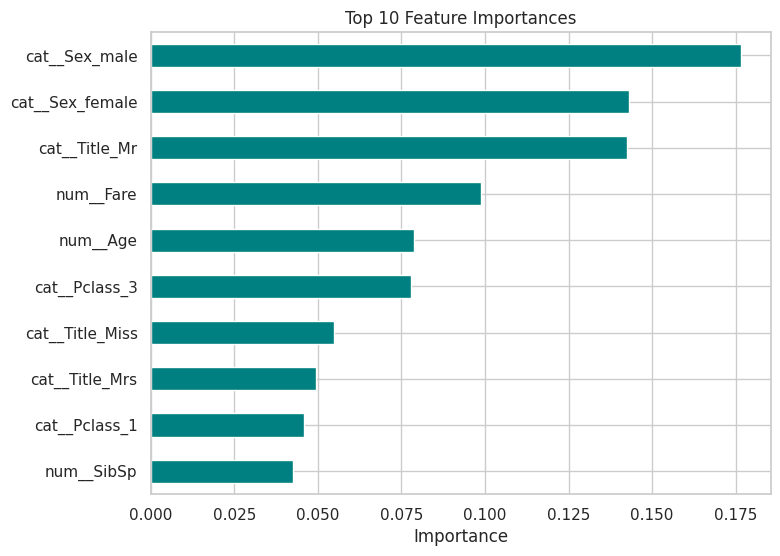

In [249]:

# Feature Importance


# Get feature names after preprocessing
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from the RandomForest
importances = model.named_steps['classifier'].feature_importances_

# Combine into a Series for easy plotting
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top 10 features
plt.figure(figsize=(8, 6))
feat_imp.head(10).plot(kind='barh', color='teal')
plt.gca().invert_yaxis()  # highest importance on top
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.show()


**Save the Model for Production**

In [250]:

#  Save Model Pipeline


import joblib

# Save entire pipeline (preprocessing + trained model)
joblib.dump(model, "titanic_model_pipeline.pkl")

print("Model pipeline saved as 'titanic_model_pipeline.pkl'.")


Model pipeline saved as 'titanic_model_pipeline.pkl'.
